In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## Market and Credit Model

In [51]:
r = 0.02  # Risk-free rate
S0 = 100  # Initial price of the underlying asset
S_bar = 100  # Strike price
kappa = 0.12  # Drift
sigma = 0.2  # Volatility
hl = 1/4  # 3 months in years
T = 5  # Maturity 5 years
delta = 1/52  # One week in years
gamma = 0.01  # Exponential default times 100 bps
dt = 1/252  # One day in years
time = np.linspace(0, T, int(T / dt) + 1) # Daily Time grid

In [52]:
S = lambda t , S0 : S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * np.sqrt(t) * np.random.normal(0, 1))

def black_scholes_paths(S0, r, sigma, T, dt, N_paths):
    """Génère des trajectoires de Black-Scholes par Euler-Maruyama"""
    N_steps = int(T / dt)
    S = np.zeros((N_steps + 1, N_paths))
    S[0] = S0
    for t in range(1, N_steps + 1):
        Z = np.random.normal(0, 1, N_paths)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

## Black-Scholes Simulation

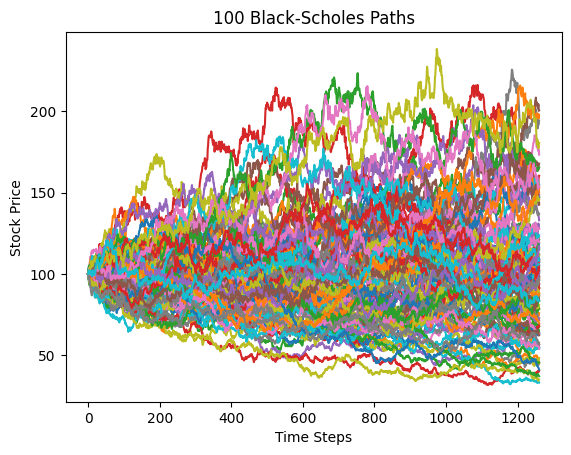

In [54]:
# Plot 100 paths

paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths = 100)
plt.plot(paths)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('100 Black-Scholes Paths')
plt.show()

## Mark-to-Market computation

In [55]:
N_paths = 5000
dt = 1/252  # Pas journalier
t_grid = np.linspace(0, T, int(T / hl) + 1)
S_paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths)
Nom = np.exp(-r * T) / (sum( [ np.exp(- r * (T - t_grid[l])) * ( np.exp(kappa * t_grid[l-1]) * S0 - S_bar) for l in range( 1 , len(t_grid)) ] ) * hl)

# 3. Calcul du processus MtM

def MtM(t, S_bar=S0):
    
    step = 1/dt
    beta_t = np.exp(r * (T - t))
    betas = np.exp(- r * (T - t_grid) )
    # The nominal (Nom) of the swap is set so that each leg has a time-0 mark-to-market of 1
    Nom = np.exp(-r * T) / (sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * S_paths[0] - S_bar) for l in range( 1 , len(t_grid)) ] ) * hl)

    # l_t is the index of t_grid such that t_grid[l_t - 1] <= t < t_grid[l_t]
    l_t = min( np.argmin(np.abs(t_grid - t)) +  1, 20)

    S_t = S_paths[int(t * step)] # S_t = S(t)
    S_hat = np.exp(-kappa * t) * S_t 

    Σ = sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * S_hat - S_bar) for l in range(l_t + 1, len(t_grid)) ] )

    MtM = Nom * beta_t * hl * ( betas[l_t] * (S_paths[int(t_grid[l_t - 1] * step)] - S_bar) + Σ)
    
    return MtM


In [56]:
MtMs = [MtM(t) for t in time]

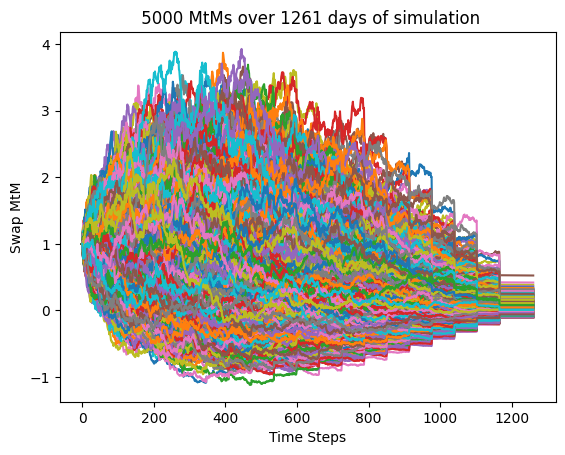

In [57]:
# Plot MtMs

plt.plot(MtMs)
plt.xlabel('Time Steps')
plt.ylabel('Swap MtM')
plt.title(f' {len(MtMs[0])} MtMs over {len(MtMs)} days of simulation')
plt.show()

## 5.1 Warm up CVA w/o RIM

In [59]:
# Auxiliary methods
def f(t):
    betas = np.exp(- r * (T - t_grid) )
    # l_t_delat is the index of t_grid such that t_grid[l_t - 1] <= t + delta < t_grid[l_t]
    l_t_delta =  min( np.argmin(np.abs(t_grid - (t + delta) )) +  1, 20)
    Σ = sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * hl) for l in range(l_t_delta + 1, len(t_grid)) ] )
    return Σ

def A(t):
    sqrt_delta = np.sqrt(delta)
    term1 = norm.cdf(sigma * sqrt_delta / 2)
    term2 = norm.cdf(-sigma * sqrt_delta / 2)
    return f(t) * (term1 - term2)


def S_hat(t, S0):
    return np.exp(-kappa * t) * S(t, S0)

S_hats = S_hat(time, S0)


In [60]:
# Computing postive part of gap risk with equation (2)
def gap_risk(t, S_hat_t):
    S_hat_t_delta = S_hat(delta, S_hat_t)
    return Nom * f(t) * max(0, (S_hat_t_delta - S_hat_t))

# Computing the left-hand side and right-hand side of equation (4)
def lhs_estimation(t, S_hat_t, N = 1000):
    return np.mean([gap_risk(t, S_hat_t) for _ in range(N)])

# Computing the right-hand side of equation (4)
def rhs_computation(t, S_hat_t):
    return Nom * A(t) * S_hat_t

LHS Estimation: 100%|██████████| 1261/1261 [00:31<00:00, 39.58it/s]


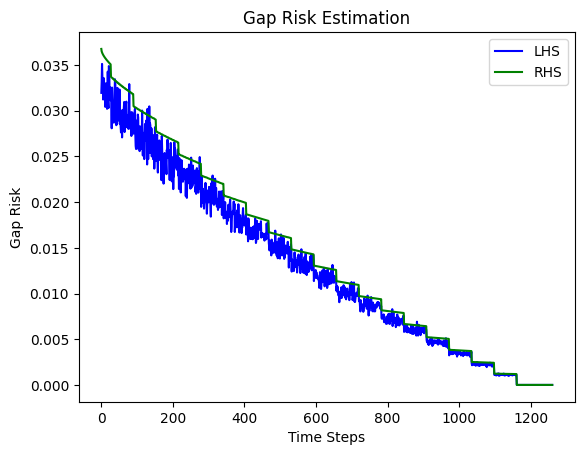

In [61]:

lhs = [ lhs_estimation(t, S_hats[int(t*(1/dt))]) for t in tqdm( time, desc='LHS Estimation') ]
rhs = [ rhs_computation(t, S_hats[int(t*(1/dt))]) for t in time ]

plt.plot(lhs, label='LHS', color='blue')
plt.plot(rhs, label='RHS', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Gap Risk')
plt.title('Gap Risk Estimation')
plt.legend()
plt.show()

### 1 - Linear regress vs. train a (one layer) linear neural network 
to learn the left-hand side in (4) at grid times t.

In [62]:
# regression model vs 1-Layer NN with data from lhs 
data = {'y' : lhs, 'x1': S_hats, 'x2': time}
df = pd.DataFrame(data)

X = df[['x1', 'x2']].values
y = df['y'].values
df.head()

,y,x1,x2
0,0.031952,100.000000,0.000000
1,0.033138,99.273845,0.003968
2,0.035119,98.947004,0.007937
3,0.033690,98.686004,0.011905
4,0.033542,98.459148,0.015873


In [63]:

reg_linear = LinearRegression()
reg_linear.fit(X, y)
y_pred_linear = reg_linear.predict(X)
y_pred_linear

array([ 0.03418188,  0.033783  ,  0.0336016 , ..., -0.0010482 ,
       -0.00106503, -0.00108185])

In [64]:


# 1-Layer NN
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)
    
# Hyperparameters
input_size = 2  # x1 and x2
output_size = 1  # y
num_epochs = 1000
learning_rate = 0.01
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function and optimizer
model = SimpleNN(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc='Training NN'):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()


Training NN:   0%|          | 0/1000 [00:00<?, ?it/s]

Training NN: 100%|██████████| 1000/1000 [00:20<00:00, 49.15it/s]


In [65]:

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_tensor).cpu().numpy().flatten()

y_pred_nn

array([ 0.0057669 ,  0.00556886,  0.00547064, ..., -0.02924764,
       -0.02927035, -0.02929305], dtype=float32)

### - 2 Validate by (all at each grid time t)
 - a. the formula (4),
 - b. twin Monte Carlo for conditional expectations,
 - c. nested Monte Carlo

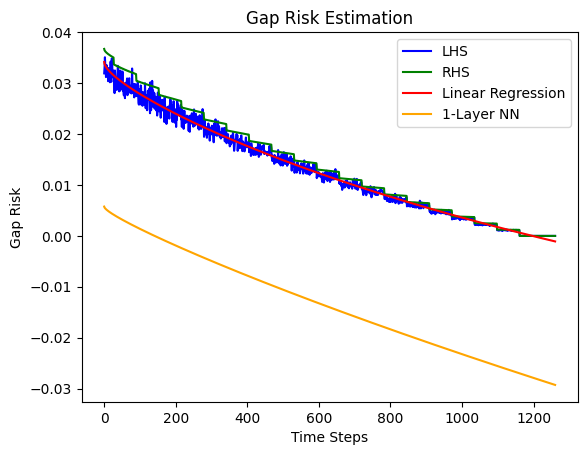

In [66]:

# Plotting the results
plt.plot(lhs, label='LHS', color='blue')
plt.plot(rhs, label='RHS', color='green')
plt.plot(y_pred_linear, label='Linear Regression', color='red')
plt.plot(y_pred_nn, label='1-Layer NN', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Gap Risk')
plt.title('Gap Risk Estimation')
plt.legend()
plt.show()


### 3 - Deduce ``CVA_0`` by numerical integration and Monte Carlo
based on your predictors plugged in the last line in (7). Validate the result by the explicit formula (6).

In [67]:
# Define gamma_1(t) as a constant function

def gamma_1(t):
    return gamma

# Compute the integral of gamma_1(s) from 0 to t (simplified since gamma is constant)
def integral_gamma_1(t):
    return gamma * t

# Define the explicit formula for CVA_0
def CVA_explicit(Nom, S0):
    def integrand(t):
        A_t = A(t)
        exp_term = np.exp(-integral_gamma_1(t))
        return A_t * exp_term * gamma_1(t)
    
    result, _ = quad(integrand, 0, T)
    return Nom * S0 * result

# Monte Carlo simulation for CVA_0
def CVA_monte_carlo(N = 1000, regression = True):
    if regression:
        predictor = lambda s, t: reg_linear.predict([[s, t]])[0]
    else:
        predictor = lambda s, t: model(torch.tensor([[s, t]], dtype=torch.float32).to(device)).cpu().detach().numpy()[0][0]

    cva_values = []
    for i in tqdm(range(N), desc ='CVA Monte Carlo Simulation'):
        def integrand(t):
            predictor_t = predictor( S_hat(t, S0) , t)
            return predictor_t * np.exp(-integral_gamma_1(t)) * gamma_1(t)
        
        result, _ = quad(integrand, 0, T)
        cva_values.append(result)
    
    return np.mean(cva_values)

In [68]:
import warnings
warnings.filterwarnings("ignore")

# Compute CVA using explicit formula
cva_explicit = CVA_explicit(Nom, S0)
print("CVA (Explicit Formula):", cva_explicit)

# Compute CVA using Monte Carlo (linear regression)
cva_monte_carlo = CVA_monte_carlo()
print("CVA (Monte Carlo with regression plugged):", cva_monte_carlo)

# Compute CVA using Monte Carlo (1-layer NN)
cva_monte_carlo_nn = CVA_monte_carlo(regression=False)
print("CVA (Monte Carlo with 1-layer NN):", cva_monte_carlo_nn)


CVA (Explicit Formula): 0.0009458984116349173


CVA Monte Carlo Simulation: 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


CVA (Monte Carlo with regression plugged): 0.0009977397029674543


CVA Monte Carlo Simulation: 100%|██████████| 1000/1000 [02:16<00:00,  7.34it/s]

CVA (Monte Carlo with 1-layer NN): -0.00048277905822715516


### 4 - Replacing “Linear regress vs. train a (one layer) linear neural network to learn” by “Polynomial vs. (nonlinear) NN train”
redo 1.–3. above for an at-the-money call instead of the above swap, i.e. ``MtMt = callbs(t, S_t, T,K)`` with ``K = S0`` (and ``∆ = 0`` as there are here no intermediary cash flows involved). You then lose the closed formulas, but the twin and the nested Monte Carlo still allow validating your predictors.


In [21]:
def call_bs(t, S_t, K = S0):
    """Calcul du prix d'une option d'achat européenne selon le modèle de Black-Scholes"""
    d1 = (np.log(S_t / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    call_price = S_t * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    return call_price


def gap_risk_call(t, S_t):
    beta_t = np.exp(r * (T - t))
    beta_t_delta = np.exp(r * (T - (t + delta)))

    S_t_delta = S_t * np.exp((r - 0.5 * sigma**2) * delta + sigma * np.sqrt(delta) * np.random.normal(0, 1))

    call_bs_t = call_bs(t, S_t)
    call_bs_t_delta = call_bs(t + delta, S_t_delta)

    return max(0, beta_t_delta * call_bs_t_delta - beta_t * call_bs_t)

# Computing the left-hand side and right-hand side of equation (4)
def lhs_estimation_call(t, S_t, N = 1000):
    return np.mean([gap_risk(t, S_t) for _ in range(N)])


In [ ]:
S_t = [ S(t,S0) for t in time ]
lhs_call = [ lhs_estimation_call(t, S_t[int(t*(1/dt))]) for t in tqdm( time, desc='LHS Estimation') ]

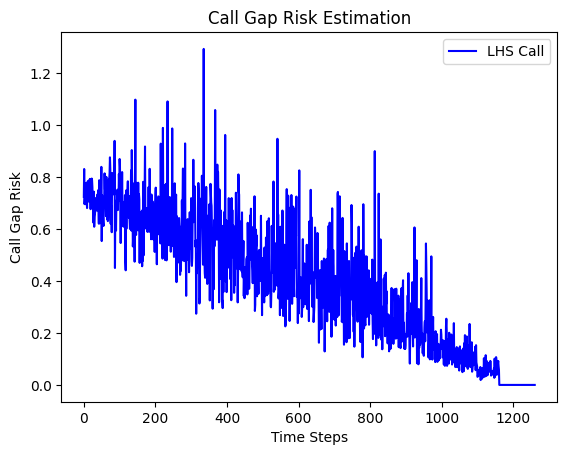

In [38]:
# plot lhs_call
plt.plot(lhs_call, label='LHS Call', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Call Gap Risk')
plt.title('Call Gap Risk Estimation')
plt.legend()
plt.show()

In [41]:
data_call = {'y' : lhs_call, 'x1': S_t, 'x2': time}
df_call = pd.DataFrame(data_call)
X_call = df_call[['x1', 'x2']].values
y_call = df_call['y'].values
df_call.head()

,y,x1,x2
0,0.723169,100.000000,0.000000
1,0.830271,101.290819,0.003968
2,0.695149,100.730829,0.007937
3,0.719855,97.649846,0.011905
4,0.721592,99.787762,0.015873


In [ ]:
# Polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_call)
reg_poly = LinearRegression()
reg_poly.fit(X_poly, y_call)
y_pred_poly = reg_poly.predict(X_poly)
y_pred_poly

array([ 0.72595969,  0.73276851,  0.72922611, ..., -0.03749173,
       -0.03492831, -0.03139803])

In [45]:
# Non-Linear Neural Network
class NonLinearNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NonLinearNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters for Non-Linear NN
input_size = 2  # x1 and x2
hidden_size = 10  # Number of neurons in the hidden layer
output_size = 1  # y
num_epochs = 1000
learning_rate = 0.01
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_tensor_call = torch.tensor(X_call, dtype=torch.float32).to(device)
y_tensor_call = torch.tensor(y_call, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader
dataset_call = torch.utils.data.TensorDataset(X_tensor_call, y_tensor_call)
dataloader_call = torch.utils.data.DataLoader(dataset_call, batch_size=batch_size, shuffle=True)

# Initialize model, loss function and optimizer
model_call = NonLinearNN(input_size, hidden_size, output_size).to(device)
criterion_call = nn.MSELoss()
optimizer_call = optim.Adam(model_call.parameters(), lr=learning_rate)
# Training loop for Non-Linear NN
for epoch in tqdm(range(num_epochs), desc='Training Non-Linear NN'):
    for batch_X, batch_y in dataloader_call:
        optimizer_call.zero_grad()
        outputs = model_call(batch_X)
        loss = criterion_call(outputs, batch_y)
        loss.backward()
        optimizer_call.step()

# Evaluate the model
model_call.eval()
with torch.no_grad():
    y_pred_nn_call = model_call(X_tensor_call).cpu().numpy().flatten()

y_pred_nn_call

Training Non-Linear NN: 100%|██████████| 1000/1000 [00:23<00:00, 41.84it/s]


array([ 0.72743183,  0.73164594,  0.729271  , ..., -0.0422174 ,
       -0.05758798, -0.01982191], dtype=float32)

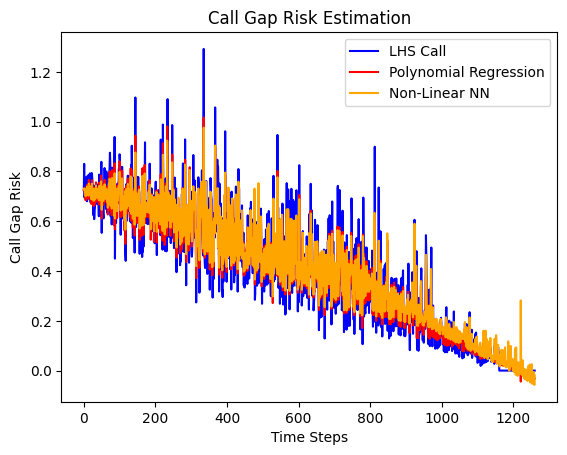

In [46]:
# plotting the results
plt.plot(lhs_call, label='LHS Call', color='blue')
plt.plot(y_pred_poly, label='Polynomial Regression', color='red')
plt.plot(y_pred_nn_call, label='Non-Linear NN', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Call Gap Risk')
plt.title('Call Gap Risk Estimation')
plt.legend()
plt.show()